In [28]:
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import linear_model
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV

from data_preporation import prepare, get_cabin_id
from data_preporation import get_family_id
from data_preporation import get_ticket_prefix_id
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from utils import plot_learning_curve
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

In [29]:
# Print you can execute arbitrary python code
train = pd.read_csv("data/train.csv", dtype={"Age": np.float64}, )
test = pd.read_csv("data/test.csv", dtype={"Age": np.float64}, )

In [30]:
# Family distribution
family_id_mapping = {}
train.apply(lambda row: get_family_id(row, family_id_mapping), axis=1)
test.apply(lambda row: get_family_id(row, family_id_mapping), axis=1);

In [31]:
# Ticket distribution
get_ticket_prefix_id_mapping = {}
train.apply(lambda row: get_ticket_prefix_id(row, get_ticket_prefix_id_mapping), axis=1)
test.apply(lambda row: get_ticket_prefix_id(row, get_ticket_prefix_id_mapping), axis=1);

In [32]:
# cabin distribution
cabin_id_mapping = {}
train.apply(lambda row: get_cabin_id(row, cabin_id_mapping), axis=1)
test.apply(lambda row: get_cabin_id(row, cabin_id_mapping), axis=1);

In [33]:
prepare(train, family_id_mapping, get_ticket_prefix_id_mapping, cabin_id_mapping);

-1.62003165255e+12


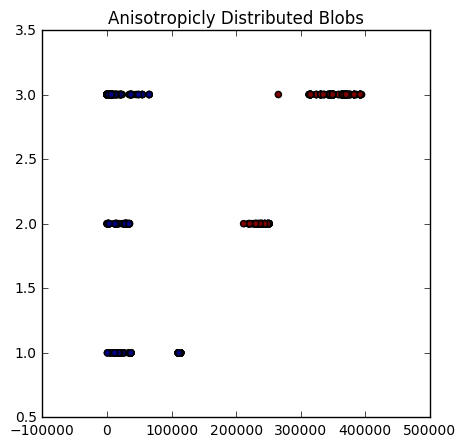

In [38]:
random_state = 170
KMF = ['Ticket_s', 'Pclass', 'CabinN']
kmx = train[KMF]

km_model = KMeans(n_clusters=2, random_state=random_state).fit(kmx)
print(km_model.score(kmx))
y_pred = km_model.predict(kmx)

plt.figure(figsize=(5, 5))
plt.scatter(train[['Ticket_s']], train[['Pclass']], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")
plt.show()
    

train['Ticket_s_g'] = y_pred;

In [39]:
predictors = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'SibSp', 'Parch', 'FamilySize', 'NameLength', 'Title',
              'FamilyId', 'CabinN']

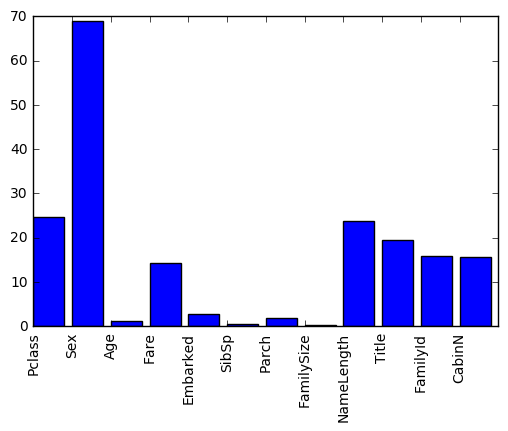

In [40]:
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(train[predictors], train["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [41]:
polynomial_features = PolynomialFeatures(degree=1, include_bias=False)
alg = linear_model.LogisticRegression()
#alg = RandomForestClassifier(n_estimators=22)
#alg = SVC()

In [42]:
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("logistic_regression", alg)])
scores = cross_val_score(
    pipeline,
    train[predictors],
    train["Survived"],
    cv=3
)

In [43]:
scores

array([ 0.7979798 ,  0.81144781,  0.83838384])

In [44]:
scores.mean()

0.81593714927048255

Plot scores [ 0.88135593  0.84455959  0.8190184   0.82318841  0.81986532]


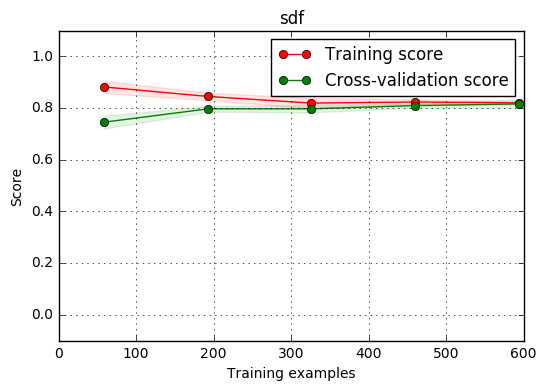

In [45]:
plot_learning_curve(pipeline, "sdf", train[predictors], train["Survived"], (-0.1, 1.1), cv=3, n_jobs=1)
plt.show()

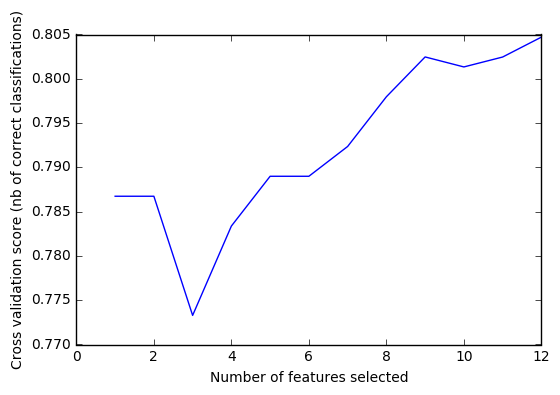

In [46]:
#Optimal number of features and visualize this
rfecv_X = train[predictors]
rfecv_Y = train["Survived"]
rfecv = RFECV( estimator = alg , step = 1 , cv = StratifiedKFold( rfecv_Y , 2 ) , scoring = 'accuracy' )
rfecv.fit( rfecv_X , rfecv_Y )
plt.figure()
plt.xlabel( "Number of features selected" )
plt.ylabel( "Cross validation score (nb of correct classifications)" )
plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
plt.show()

In [47]:
#TEST
prepare(test, family_id_mapping, get_ticket_prefix_id_mapping, cabin_id_mapping)
test['Ticket_s_g'] = km_model.predict(test[KMF])

In [48]:
# Train the algorithm using all the training data
alg.fit(train[predictors], train["Survived"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
# Make predictions using the test set.
predictions = alg.predict(test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})
submission.to_csv("data/kaggle.csv", index=False)